In [1]:
import os
from collections import namedtuple
from haralyzer import HarParser, HarPage
from pathlib import Path


Measurement = namedtuple('Measurement', 'hostname config run ttfb plt')

def get_measurements(base_path):
    pathlist = Path(base_path).glob('**/*/*.har')
    sites = {}
    configs = set()
    for p in pathlist:
        f_path, f_name = os.path.split(p)
        hostname = os.path.split(f_path)[-1]
        _, config, run = f_name[:-4].split('-')
        configs.add(config)
        ttfb, plt = parse_har_file(p)
        if ttfb is None or plt is None:
            continue 
        
        sites.setdefault(hostname, {})
        sites[hostname].setdefault(config, [])
        sites[hostname][config].append(Measurement(hostname, config, run, ttfb, plt))
    
    return sites, list(configs)

def parse_har_file(path):
    with open(path, 'r') as f:
        try:
            har_page = HarPage('page_1', har_data=json.loads(f.read()))
            return har_page.time_to_first_byte, har_page.page_load_time
        except:
            print(f'Failed to parse HAR file from {path}')

    return None, None

results_path = 'gce'
measurements, configs = get_measurements(results_path)

In [2]:
def analyze(measurements, base_config='BYPASS_PROXY', proxy_config='QUIC_PROXY'):
    sites = {}
    skipped = []
    ttfbs = []
    plts = []
    
    all_avg_plts = {}
    all_avg_ttfbs = {}
    
    for hostname, data in measurements.items():
        if base_config not in data or proxy_config not in data:
            skipped.append(hostname)
            continue
        
        averages = {}
        for config, config_measurements in data.items():
            ttfb, plt = zip(*[(cm.ttfb, cm.plt) for cm in config_measurements])
            avg_ttfb = np.mean(np.asarray(ttfb)) / 1000.0
            avg_plt = np.mean(np.asarray(plt)) / 1000.0
            averages[config] = Measurement(hostname, config, -1, avg_ttfb, avg_plt)
            all_avg_plts.setdefault(config, [])
            all_avg_plts[config].append(avg_plt)
            
            all_avg_ttfbs.setdefault(config, [])
            all_avg_ttfbs[config].append(avg_ttfb)
        
        plt_diff = (averages[proxy_config].plt - averages[base_config].plt)
        ttfb_diff = (averages[proxy_config].ttfb - averages[base_config].ttfb)
        sites[hostname] = Measurement(hostname, None, None, ttfb_diff, plt_diff)
        ttfbs.append(ttfb_diff)
        plts.append(plt_diff)
        
    return ttfbs, plts, all_avg_plts, all_avg_ttfbs, skipped
        
ttfb_diffs, plt_diffs, all_avg_plts, all_avg_ttfbs, skipped = analyze(measurements)

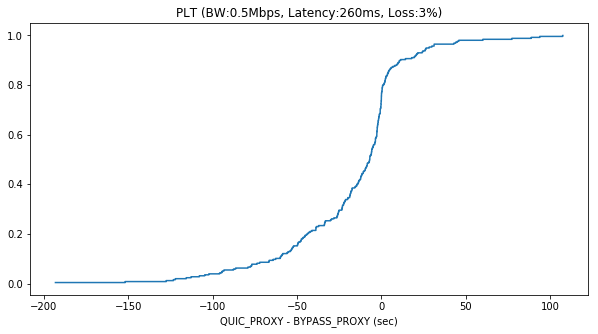

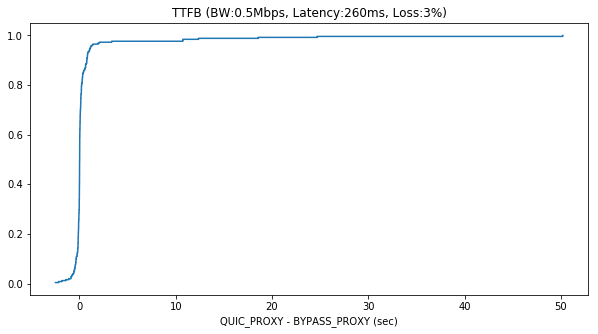

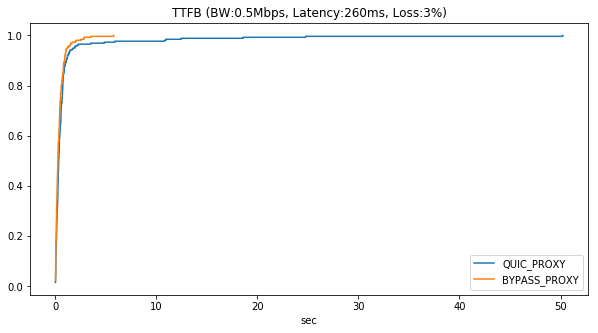

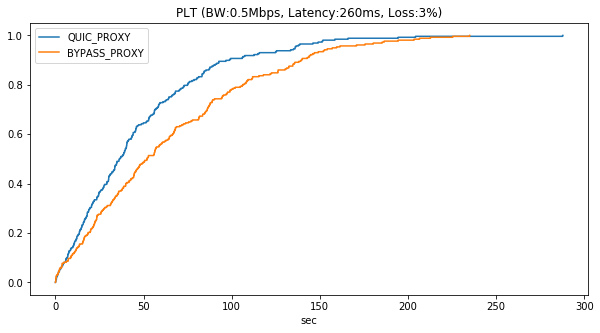

In [6]:
import statsmodels.api as sm
import matplotlib.pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = 10,5

def plot_cdf(data, title, xlabel):
    ecdf = sm.distributions.ECDF(data)
    x = np.linspace(min(data), max(data), 10000)
    y = ecdf(x)
    plt.step(x,y)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.show()

    
def plot_dual_cdf(data, configs, title):
    fig, ax = plt.subplots()
    
    for c in configs:
        d = data[c]
        ecdf = sm.distributions.ECDF(d)
        x = np.linspace(0, max(d), 10000)
        y = ecdf(x)
        ax.step(x,y, label=c)
    plt.xlabel('sec')
    plt.legend()
    plt.title(title)
    plt.show()
    
plot_cdf(plt_diffs, 'PLT (BW:0.5Mbps, Latency:260ms, Loss:3%)', 'QUIC_PROXY - BYPASS_PROXY (sec)')
plot_cdf(ttfb_diffs, 'TTFB (BW:0.5Mbps, Latency:260ms, Loss:3%)', 'QUIC_PROXY - BYPASS_PROXY (sec)')

plot_dual_cdf(all_avg_ttfbs, ['QUIC_PROXY', 'BYPASS_PROXY'], 'TTFB (BW:0.5Mbps, Latency:260ms, Loss:3%)')
plot_dual_cdf(all_avg_plts, ['QUIC_PROXY', 'BYPASS_PROXY'], 'PLT (BW:0.5Mbps, Latency:260ms, Loss:3%)')